# Iris 베스트 모델 찾은 후 자동 중단

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

### 데이터 전처리

In [2]:
iris = pd.read_csv('dataset/iris.csv', header=None)
iris.head(3)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [3]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(iris.iloc[:,-1].values)

In [4]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(y)
y_onehot[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [5]:
# 데이터 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(iris.iloc[:,:-1].values)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, y_onehot, stratify=y_onehot, random_state=seed
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((112, 4), (38, 4), (112, 3), (38, 3))

### 모델 정의/설정

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
model = Sequential()
model.add(Dense(16, input_dim=4, activation='relu'))    # Hidden layer
model.add(Dense(3, activation='softmax'))               # Output layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
)

### 모델 저장조건 설정

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
modelpath = 'model/best_iris.h5'
checkpointer = ModelCheckpoint(
    modelpath, monitor='val_loss', verbose=0, save_best_only=True
)
early_stopping = EarlyStopping(patience=30)

### 모델 학습 및 저장

In [12]:
history = model.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=2000, batch_size=30, verbose=0,
    callbacks=[checkpointer, early_stopping]
)

### 베스트 모델 로딩후 평가

In [13]:
from tensorflow.keras.models import load_model
best_model = load_model(modelpath)

In [14]:
best_model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 1ms/step - loss: 0.0612 - accuracy: 1.0000


[0.06116102263331413, 1.0]

### 훈련과정 시각화

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
y_acc = history.history['accuracy']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_acc))

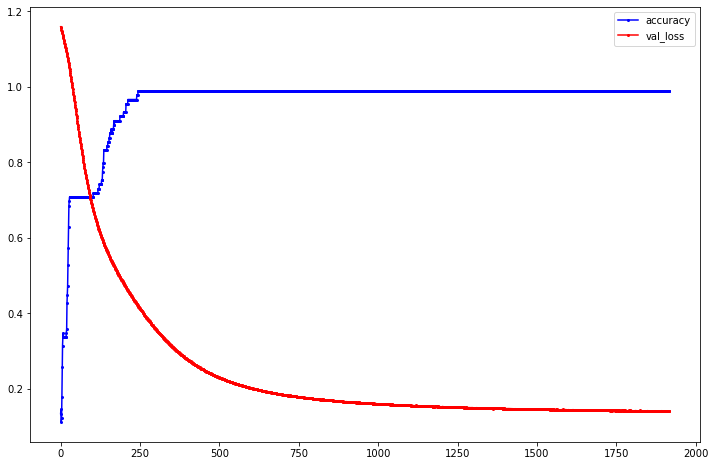

In [17]:
plt.figure(figsize=(12,8))
plt.plot(x_len, y_acc, 'bo-', markersize=2, label='accuracy')
plt.plot(x_len, y_vloss, 'ro-', markersize=2, label='val_loss')
plt.legend()
plt.show()